In [1]:
%matplotlib inline
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import astropy.io as ap
import time
from joblib import Parallel, delayed

In [2]:
start = time.time()

NSIDE = 1024
NPIX = hp.nside2npix(NSIDE)
NPIX
day = 60*60*24#1日の秒数
year = day*365
times = year*3 +1
time_array = np.arange(0,times,1)


In [3]:

orbit_file = "orbit_angle.npz"
#orbit_fileからtimes秒まで読み込み，times秒間フライトしたデータを取得する．
#orbit = np.array([np.load(orbit_file)["theta"][:times], np.load(orbit_file)["phi"][:times]])

orbit = np.load(orbit_file)
orbit = np.array([orbit["theta"][:times], orbit["phi"][:times]])

In [4]:
elapsed_time0 = time.time() - start
print ("\n計算時間: {0}".format(elapsed_time0) + "[sec]")

pix = hp.ang2pix(NSIDE,orbit[0],orbit[1])
#ヒストグラムの処理は長い
#hit_pix, bins = np.histogram(pix,bins=NPIX)


計算時間: 9.46140718460083[sec]


In [5]:

"""Planckのマップをreadして解析する"""
file_path = "COM_CMB_IQU-nilc_1024_R2.02_full.fits"
I_planck = hp.read_map(file_path,field = 0)#PlanckのRING型データ
I_obs = I_planck[pix]#Planckのデータを観測されるpix順に並び換えた時系列観測データI_obs

I_map = np.zeros(NPIX)
I_map[pix[:]] = I_planck[pix]

/Users/yusuke/.pyenv/versions/3.8.0/lib/python3.8/site-packages/healpy/fitsfunc.py:351: UserWarning: If you are not specifying the input dtype and using the default np.float64 dtype of read_map(), please consider that it will change in a future version to None as to keep the same dtype of the input file: please explicitly set the dtype if it is important to you.
  warnings.warn(


NSIDE = 1024
ORDERING = NESTED in fits file
INDXSCHM = IMPLICIT


/Users/yusuke/.pyenv/versions/3.8.0/lib/python3.8/site-packages/healpy/fitsfunc.py:403: UserWarning: No INDXSCHM keyword in header file : assume IMPLICIT
  warnings.warn("No INDXSCHM keyword in header file : " "assume {}".format(schm))


Ordering converted to RING


In [6]:
t = time_array
w = 2*np.pi*(0.3/60)
det = np.array([np.ones(times),np.sin(2*w*t),np.zeros(times),np.cos(2*w*t)])

D_mat = np.array([
        [np.ones(times), np.sin(2*w*t),np.zeros(times),np.cos(2*w*t)],
        [np.sin(2*w*t),np.sin(2*w*t)**2,np.zeros(times),np.cos(2*w*t)*np.sin(2*w*t)],
        [np.zeros(times),np.zeros(times),np.zeros(times),np.zeros(times)],
        [np.cos(2*w*t),np.cos(2*w*t)*np.sin(2*w*t),np.zeros(times),np.cos(2*w*t)*np.cos(2*w*t)]
        ])
D_mat.sum(2)


array([[9.46080010e+07, 2.58246757e-09, 0.00000000e+00, 1.00000000e+00],
       [2.58246757e-09, 4.73040000e+07, 0.00000000e+00, 1.01112620e-08],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [1.00000000e+00, 1.01112620e-08, 0.00000000e+00, 4.73040010e+07]])

In [7]:
sum_D_pinv = np.linalg.pinv(D_mat.sum(2))
sum_D_pinv


array([[ 1.05699305e-08, -5.77044272e-25,  0.00000000e+00,
        -2.23446861e-16],
       [-5.77044215e-25,  2.11398613e-08,  0.00000000e+00,
        -5.84807934e-24],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-2.23446861e-16,  1.19290890e-24,  0.00000000e+00,
         2.11398609e-08]])

In [8]:
D_E = np.dot(D_mat.sum(2), sum_D_pinv)
sum_D_pinv

array([[ 1.05699305e-08, -5.77044272e-25,  0.00000000e+00,
        -2.23446861e-16],
       [-5.77044215e-25,  2.11398613e-08,  0.00000000e+00,
        -5.84807934e-24],
       [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-2.23446861e-16,  1.19290890e-24,  0.00000000e+00,
         2.11398609e-08]])

In [9]:
wp = det*I_obs
sum_wp = wp.sum(1)
sum_wp

array([ 9.33087747e+01,  5.59905525e-03,  0.00000000e+00, -1.23943859e+01])

In [10]:
s_tilde = np.dot(sum_D_pinv, sum_wp)
s_tilde

array([ 9.86267271e-07,  1.18363252e-10,  0.00000000e+00, -2.62015615e-07])

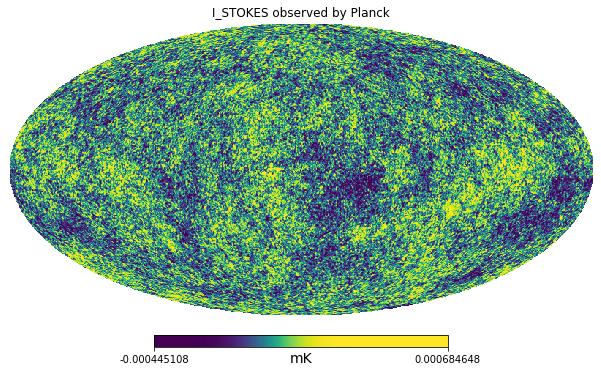

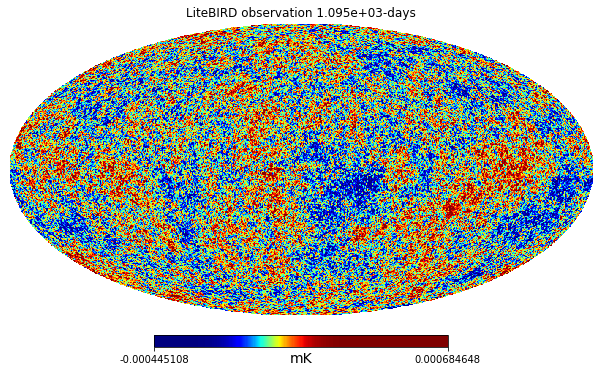

In [11]:
hp.mollview(I_planck, title="I_STOKES observed by Planck", unit="mK",norm="hist")
hp.mollview(I_map, title="LiteBIRD observation {:.4}-days".format(times/(day+1)), unit="mK",norm="hist",cmap="jet")